Extract Intensity and GLCM features from MRI Images and Preprocess Data for ML Models

In [1]:
#Necessary Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.stats import entropy
from skimage.feature import graycomatrix, graycoprops
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Define Dataset Paths

<div style="font-size:85%">
  
1. Set IMAGE_PATH to the images directory.  
2. Set MASK_PATH to the masks directory.  
3. Set LABELS_CSV to the labels CSV file path.  
4. Set OUTPUT_CSV to the output features CSV file path.  

</div>

In [2]:
IMAGE_PATH = r"C:\Users\rithv\GitHub\brain-mri-scans\code\images"
MASK_PATH = r"C:\Users\rithv\GitHub\brain-mri-scans\code\masks"
LABELS_CSV = r"C:\Users\rithv\GitHub\brain-mri-scans\code\labels.csv"
OUTPUT_CSV = r"C:\Users\rithv\GitHub\brain-mri-scans\code\extracted_features.csv"

Define Feature Extraction Function

<div style="font-size:85%">
  
1. Read labels CSV into DataFrame.  
2. Initialize rows list.  
3. Loop over each row:  
   1. Get filename and label.  
   2. Build full image and mask paths.  
   3. Load image and convert to grayscale.  
   4. Load mask.  
   5. Calculate intensity features: mean, std, variance, min, max, skewness, kurtosis, energy, entropy.  
   6. Compute GLCM matrix.  
   7. Calculate GLCM properties: contrast, dissimilarity, ASM, correlation, energy, homogeneity.  
   8. Calculate additional GLCM features: entropy, autocorrelation, IDM, max prob, variance, sum avg, sum entropy, cluster shade.  
   9. Append feature dict to rows.  
4. Create DataFrame from rows.  
5. Save to CSV.   
6. Print Completion and return DataFrame.  

</div>

In [3]:
def extract_features(image_path, mask_path, labels_csv, output_csv):
    df_labels = pd.read_csv(labels_csv)
    rows = []

    for i, row in df_labels.iterrows():
        filename = row["filename"]
        label = row["target"]

        image_path_full = os.path.join(image_path, filename)
        mask_path_full = os.path.join(mask_path, filename.replace(".png", "_mask.png"))

        image = np.array(Image.open(image_path_full))
        gray_image = image[:, :, 0]  # Convert to grayscale by taking one channel
        mask = np.array(Image.open(mask_path_full))

        # Intensity Features
        mean_intensity = np.mean(gray_image)
        std_intensity = np.std(gray_image)
        variance_intensity = np.var(gray_image)
        min_intensity = np.min(gray_image)
        max_intensity = np.max(gray_image)
        skewness_intensity = skew(gray_image, axis=None)
        kurtosis_intensity = kurtosis(gray_image, axis=None)
        hist, _ = np.histogram(gray_image, bins=256, range=(0, 255), density=True)
        energy_intensity = np.sum(hist**2)
        entropy_intensity = entropy(hist + 1e-10)

        # GLCM Features
        glcm = graycomatrix(
            gray_image,
            distances=[1],
            angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
            levels=256,
            symmetric=True,
            normed=True
        )

        glcm_contrast = np.mean(graycoprops(glcm, 'contrast'))
        glcm_dissimilarity = np.mean(graycoprops(glcm, 'dissimilarity'))
        glcm_asm = np.mean(graycoprops(glcm, 'ASM'))
        glcm_correlation = np.mean(graycoprops(glcm, 'correlation'))
        glcm_energy = np.mean(graycoprops(glcm, 'energy'))
        glcm_homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))

        P = glcm[:, :, 0, 0]  # Extract 2D GLCM
        i, j = np.indices(P.shape)

        glcm_entropy = -np.sum(P * np.log2(P + 1e-10))
        glcm_autocorrelation = np.sum(i * j * P)
        glcm_idm = np.sum(P / (1 + (i - j) ** 2))
        glcm_max_prob = np.max(P)
        glcm_variance = np.var(P)
        glcm_sum_avg = np.sum(i * np.sum(P, axis=1))
        glcm_sum_entropy = -np.sum((i + j) * P * np.log2((i + j) * P + 1e-10))
        glcm_cluster_shade = np.sum(((i + j - 2*np.mean(P))**3) * P)

        rows.append({
            "filename": filename,
            "label": label,
            "mean_intensity": mean_intensity,
            "std_intensity": std_intensity,
            "variance_intensity": variance_intensity,
            "min_intensity": min_intensity,
            "max_intensity": max_intensity,
            "skewness": skewness_intensity,
            "kurtosis": kurtosis_intensity,
            "energy_intensity": energy_intensity,
            "entropy_intensity": entropy_intensity,
            "glcm_contrast": glcm_contrast,
            "glcm_dissimilarity": glcm_dissimilarity,
            "glcm_asm": glcm_asm,
            "glcm_correlation": glcm_correlation,
            "glcm_energy": glcm_energy,
            "glcm_homogeneity": glcm_homogeneity,
            "glcm_entropy": glcm_entropy,
            "glcm_autocorrelation": glcm_autocorrelation,
            "glcm_idm": glcm_idm,
            "glcm_max_prob": glcm_max_prob,
            "glcm_variance": glcm_variance,
            "glcm_sum_avg": glcm_sum_avg,
            "glcm_sum_entropy": glcm_sum_entropy,
            "glcm_cluster_shade": glcm_cluster_shade
        })

    df_features = pd.DataFrame(rows)
    df_features.to_csv(output_csv, index=False)
    print(f"Feature extraction completed. Features saved to {output_csv}")
    return df_features


Define Correlation Heatmap Plotting Function

<div style="font-size:85%">
  
1. Select numeric columns.  
2. Drop 'label' column if present.  
3. Compute correlation matrix.    
4. Plot heatmap with annotations.  
5. Set title and show.  

</div>

In [4]:
def plot_correlation_heatmap(df, title):
    df_numeric = df.select_dtypes(include=[np.number])
    df_features_only = df_numeric.drop(columns=["label"], errors='ignore')

    corr = df_features_only.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(title)
    plt.show()


Define Function to Remove Highly Correlated Features

<div style="font-size:85%">
  
1. Compute absolute correlation matrix.  
2. Get upper right-hand triangle.  
3. Find columns to drop based on threshold.  
4. Drop columns.  
5. Return reduced DataFrame and dropped list.  

</div>

In [5]:
def remove_highly_correlated(df, threshold=0.85):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [
        column for column in upper.columns
        if any(upper[column] > threshold)
    ]

    return df.drop(columns=to_drop), to_drop


Execute Feature Extraction


In [6]:
df_features = extract_features(IMAGE_PATH, MASK_PATH, LABELS_CSV, OUTPUT_CSV)


Feature extraction completed. Features saved to C:\Users\rithv\GitHub\brain-mri-scans\code\extracted_features.csv


Remove Highly Correlated Features

<div style="font-size:85%">
  
1. Drop 'filename' and 'label' from df_features.  
2. Call remove_highly_correlated function.  
3. Assign to df_reduced and dropped_features.  
4. Print dropped features.  

</div>

In [7]:
df_reduced, dropped_features = remove_highly_correlated(df_features.drop(columns=["filename", "label"]), threshold=0.85)
print("Dropped features:", dropped_features)

Dropped features: ['std_intensity', 'variance_intensity', 'kurtosis', 'entropy_intensity', 'glcm_dissimilarity', 'glcm_asm', 'glcm_energy', 'glcm_homogeneity', 'glcm_entropy', 'glcm_autocorrelation', 'glcm_idm', 'glcm_max_prob', 'glcm_variance', 'glcm_sum_entropy', 'glcm_cluster_shade']


Plot Correlation Heatmap After Preprocessing

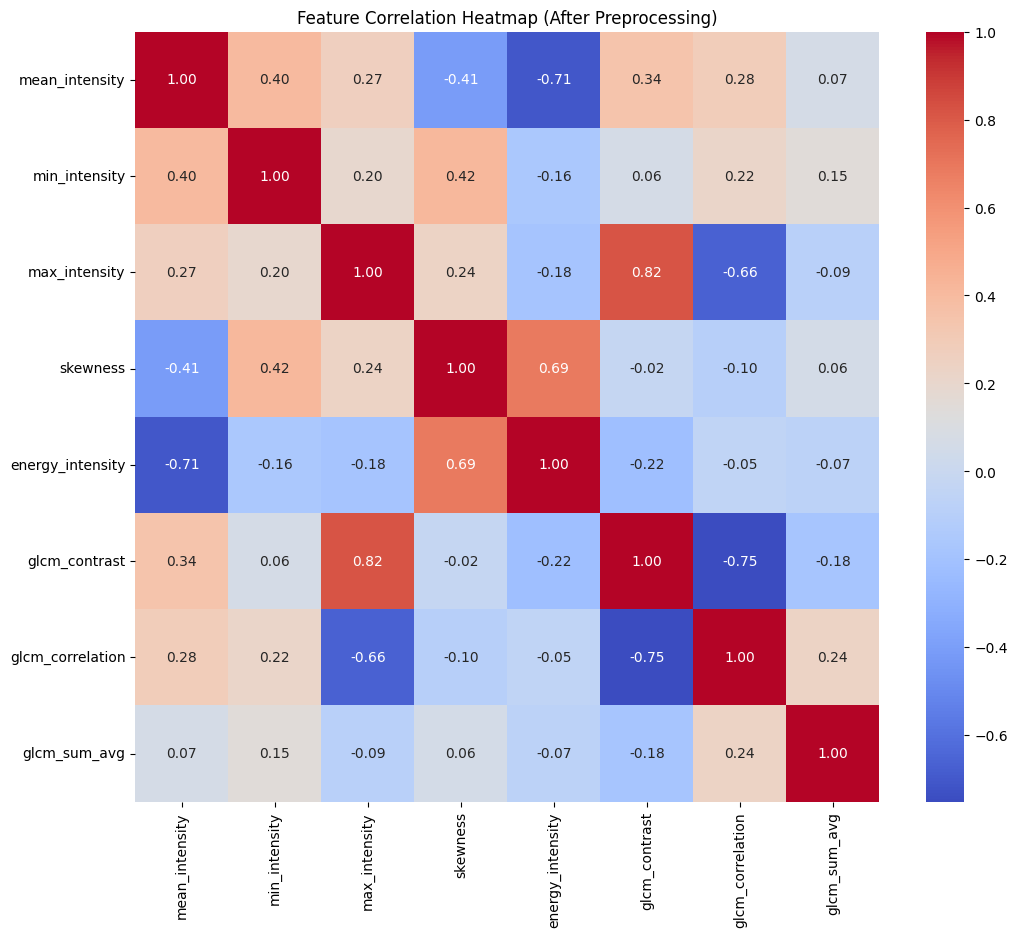

In [8]:
plot_correlation_heatmap(df_reduced.assign(label=df_features["label"]), "Feature Correlation Heatmap (After Preprocessing)")

Prepare and Save Final Dataset

<div style="font-size:85%">
  
1. Copy df_reduced to df_final.  
2. Add 'label' column.  
3. Save to 'ML_features.csv'.  
4. Print completion and final dataset shape.  

</div>

In [9]:
df_final = df_reduced.copy()
df_final["label"] = df_features["label"]

df_final.to_csv("ML_features.csv", index=False)
print("Final dataset saved as ML_features.csv")
print("Final shape:", df_final.shape)

Final dataset saved as ML_features.csv
Final shape: (300, 9)
